In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
import open3d as o3d
import nibabel as nib
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.transforms as mtransforms

INFO - 2022-01-13 15:32:45,557 - utils - Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2022-01-13 15:32:45,558 - utils - NumExpr defaulting to 8 threads.


In [2]:
FONT_TITLE_PLOT = {'family': 'sans-serif',
                   'name': 'time',
                   'color':  'black', 
                   'fontweight': 'bold',
                   'fontsize': 14}

FONT_LABEL_PLOT = {'family': 'sans-serif', 
                   'name': 'time',
                   'color':  'black', 
                   'fontweight': 'normal',
                   'fontsize': 12}

FONT_LEGEND_PLOT = {'family': 'sans-serif', 
                    'name': 'time',
                    'color':  'black', 
                    'fontweight': 'normal',
                    'fontsize': 12}


# Data import and partition

The data have already been preprocessed using the matlab class PSM (using the generateExportData function).

## Preprocessed data import

In [3]:
# Load vectorized VTA matrix
data = scipy.io.loadmat('data.mat')
X = np.array(data['X'])
y = np.array(data['y'])

# Load template container
container = nib.load('container.nii')

# Load STN polygon
pcd_read = o3d.io.read_point_cloud('templates/anatomyDISTALminimal.ply')

# Assign global variable
CONTAINER_AFFINE = container.affine
CONTAINER_SHAPE = container.shape

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO - 2022-01-13 15:33:09,280 - batteryrunners - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


## Create partitions of training and testing sets

The dataset is now split into the training and the testing set. In this script, no cross-validation will be performed.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot functions

Before going into the generation of the maps, this section creates function useful to observe and compare the probabilistic maps.

### Reconstruction of a VTA
As the data (the VTA voxels values) are provided under a vectorized form, it is necessary to be able to reconstruct the map. The first feature of the matrix is the intercept term and is cannot be displayed with the rest of the map voxels.

In [5]:
def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(image):

    # create the histogram
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim([0.0, 1.0])  # <- named arguments do not work here

    plt.plot(bin_edges[0:-1], histogram)  # <- or here
    plt.show()

def reconstruct(vector):
    # Function to reconstruct a vector into tensor based on the container shape

    intercept = vector[0]
    vector = vector[1:]
    tensor = np.reshape(vector, CONTAINER_SHAPE, order='F')

    return tensor, intercept

## Map plot
The plots of the map shall allow the vizualization of the map inside the MNI space. It is  important that the plot are easy to understand in order to give better insights about the stimulation sweet and sour spots. The function plot maps allows to plot the map in 3D (scatter) or see it in 2D as a image. In both cases the surrounding anatomy is displayed.

In [33]:
# Function used to visualize the different models
def plot_map(model,
             dim='2D', 
             plane='axial', 
             slice_index=int(CONTAINER_SHAPE[2]/2),
             view_angle=320, 
             marker='dot'):

    coef_tensor, coef_intercept = reconstruct(model.coef_)

    if dim == '2D':
        plot_slice(coef_tensor, slice_index, plane)
        
    elif dim == '3D':
        plot_cube(coef_tensor, view_angle, marker)


def plot_slice(tensor, slice_index, plane):
    # Function to plot a slice of the map on a 2D figure
    
    fig = plt.figure(figsize=(25/2.54, 25/2.54))
    ax = plt.axes()
    
    if plane == 'axial':
        plt.imshow(tensor[:, :, slice_index], cmap='coolwarm')
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'sagittal':
        plt.imshow(tensor[:, slice_index, :], cmap='coolwarm')
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'coronal':
        plt.imshow(tensor[slice_index, :, :], cmap='coolwarm')
        ax.set_xlabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    plt.show()

def plot_cube(cube, view_angle, marker):

    colors = cm.viridis(cube)
    alpha = normalize(np.power(np.abs(cube), 0.001))

    show_histogram(alpha)
    xx, yy, zz = np.indices(np.array(cube.shape))

    xx = xx.flatten()
    yy = yy.flatten()
    zz = zz.flatten()
    alpha = alpha.flatten()

    plt.figure(figsize=(20/2.54, 20/2.54))

    ax = plt.axes(projection='3d')
    ax.view_init(30, view_angle)
    ax.set_xlim(right=CONTAINER_SHAPE[0])
    ax.set_ylim(top=CONTAINER_SHAPE[1])
    ax.set_zlim(top=CONTAINER_SHAPE[2])

    if marker == 'dot':
        ax.scatter(xx, yy, zz, s=2, alpha=alpha, c=alpha, cmap='seismic', depthshade=False)

    elif marker == 'voxel':
        #ax.voxels(xx, yy, zz, colors, alpha=filled)
        ax.voxels(xx, yy, zz, facecolors=colors, edgecolor='k', shade=False)
    
    plt.show()

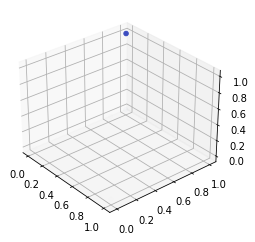

In [23]:
cube = np.array([[[10, 1000],[2, 0]], [[0, 1],[2, 3]]])
alpha = normalize(np.abs(cube))

xx, yy, zz = np.indices(np.array(cube.shape))

ax = plt.axes(projection='3d')
ax.view_init(30, 320)
ax.scatter(xx, yy, zz, c=alpha, alpha=alpha, cmap='coolwarm')

## Results plot
The results plot will be used in order to assess the quality of a model. It includes:
   - Prediction vs ground truth on testing set,
   - Prediction vs ground truth on training set,
   - Coefficient of determination of between variable prediction and ground truth,
   - Residual plot and QQ plot of those.

In [6]:
# Function used to visualize the accuracy of a model on testing and training data
def plot_results(model, X_test, y_test, X_train, y_train):

    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    coef_deter_test = model.score(X_test, y_test)
    coef_deter_train = model.score(X_train, y_train)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2)

    # Set figure size and name
    fig.tight_layout()
    fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
    fig.set_size_inches(25/2.54, 25/2.54)

    # Set axe properties
    axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
    axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[0].scatter(pred_test, y_test, s=8)
    axs[0].set_xlim([-0.05, 1.05])
    axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    axs[0].set_ylim([-0.05, 1.05])
    axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[0].set_aspect('equal', 'box')

    axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
    axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[1].scatter(pred_train, y_train, s=8)
    axs[1].set_xlim([-0.05, 1.05])
    axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    axs[1].set_ylim([-0.05, 1.05])
    axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[1].set_aspect('equal', 'box')

    # Show figure
    plt.show()

    # Print the value of the R2
    print("Coefficient of determination (R²):")
    print("     - testing  :    ", coef_deter_test)
    print("     - training :    ", coef_deter_train)

## Export map

In [21]:
def save_map(model):
    ni_img = nib.Nifti1Image(reconstruct(model.coef_)[0], CONTAINER_AFFINE)
    nib.save(ni_img, 'map.nii.gz')

# Probabilistic Stimulation for deep brain stimulation



first, I need to know wether it is a variance or a bias problem
to be assessed:
    - basic logistic regression
    - l1, l2 regularized logistic regression
    - bagging
    

## Linear regression

In [7]:
#model = LogisticRegression(C=0.1, penalty="l1", tol=0.01, solver="saga", verbose=1)

model = LinearRegression()
model = model.fit(X_train, np.squeeze(y_train.T))


WARNING - 2022-01-13 10:29:25,468 - font_manager - findfont: Font family ['time'] not found. Falling back to DejaVu Sans.
WARNING - 2022-01-13 10:29:25,483 - font_manager - findfont: Font family ['time'] not found. Falling back to DejaVu Sans.


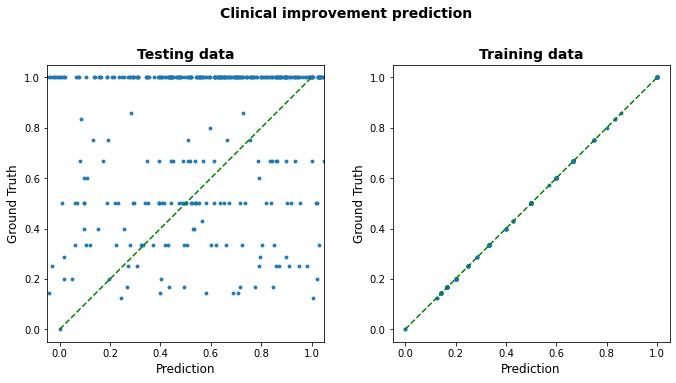

Coefficient of determination (R²):
     - testing  :     -2.8580145322110404
     - training :     1.0


In [12]:
plot_results(model, X_test, y_test, X_train, y_train)

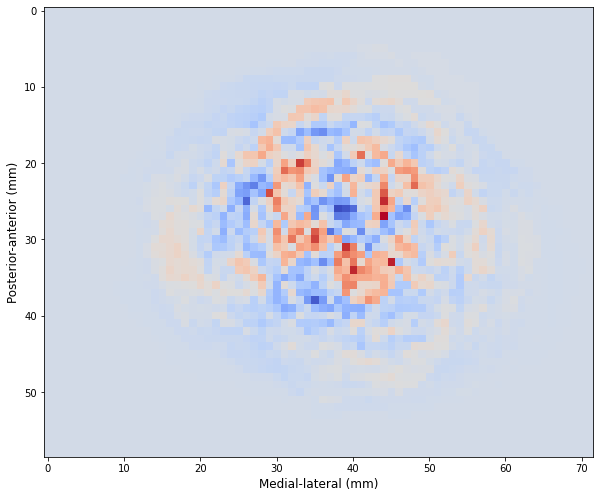

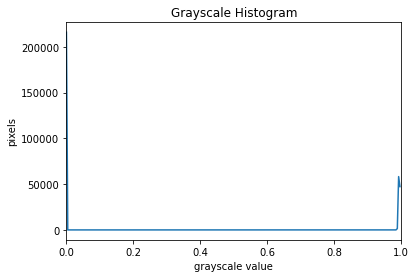

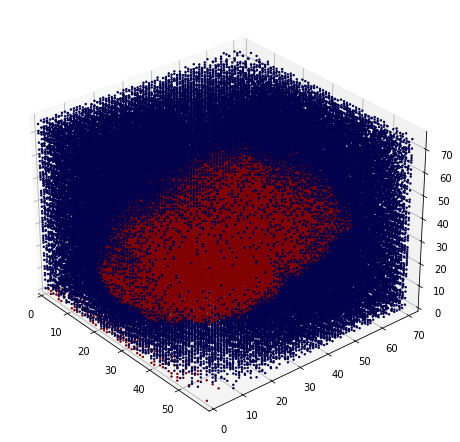

In [34]:
plot_map(model, dim='2D')
plot_map(model, dim='3D')

## Lasso regression

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01297029071669159, tolerance: 0.004537559711183355
  positive)


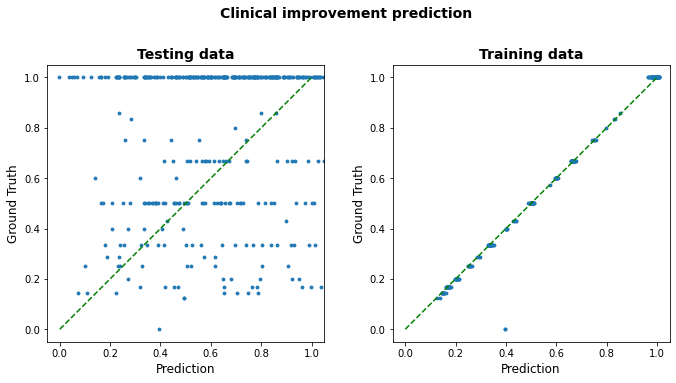

Coefficient of determination (R²):
     - testing  :     -1.1774854922321532
     - training :     0.992496759838432


In [35]:
from sklearn.linear_model import Lasso

model = Lasso(alpha = 0.0001, max_iter=1e4)
model = model.fit(X_train, np.squeeze(y_train.T))

plot_results(model, X_test, y_test, X_train, y_train)


## Logistic Regression

In [36]:
from sklearn.linear_model import LinearRegression

class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

model = LogitRegression()
model.fit(X, np.squeeze(y.T))

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('<f4').

## Bagging (SVR)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished


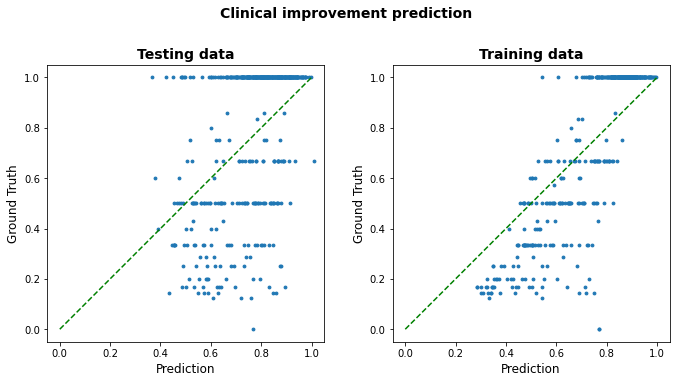

Coefficient of determination (R²):
     - testing  :     0.2296771293702382
     - training :     0.6697720413561082


In [40]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

model = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=0, verbose=1)
model = model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config

steps = [
    ("preprocessing", StandardScaler()),
    ("classifier", LogisticRegression()),
]
pipe = Pipeline(steps)


clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

In [41]:
plot_map(model, dim='2D')

AttributeError: 'BaggingRegressor' object has no attribute 'coef_'

### Support Vector Regression

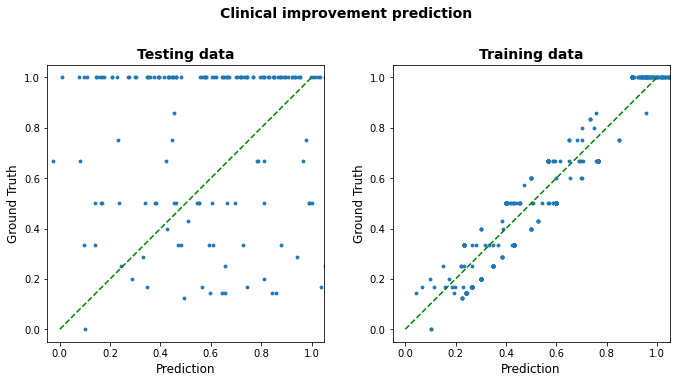

Coefficient of determination (R²):
     - testing  :     -2.165954830202331
     - training :     0.9044778377332352


In [65]:
model = SVR(kernel='linear')
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

## Pipeline
### Dimensionality reduction

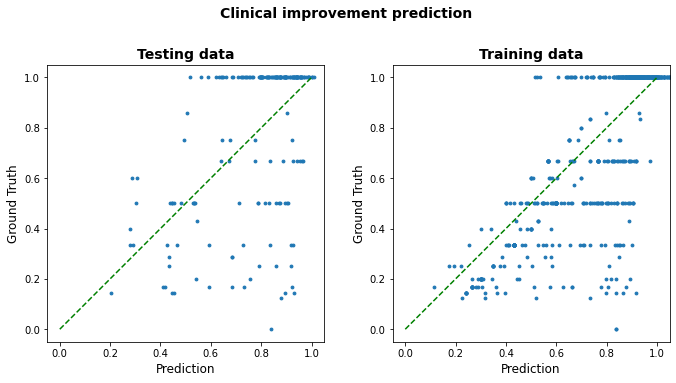

Coefficient of determination (R²):
     - testing  :     0.22553475022801683
     - training :     0.6424370687547605


In [70]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import set_config

steps = [("reduce_dim", PCA(n_components=100)), ("regressor", SVR(kernel="rbf"))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

### Feature selection

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn import set_config

steps = [("feature selection", SelectFromModel(estimator=Lasso())
), ("regressor", RandomForestRegressor(max_depth=2, random_state=0))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


ValueError: Found array with 0 feature(s) (shape=(742, 0)) while a minimum of 1 is required.

In [22]:
save_map(model)